In [2]:
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, decomposition, manifold
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from scipy.misc import imresize
from skimage import feature

In [3]:
# Load Data
data = pickle.load(open("./data/data-demo.pkl", 'rb'))
# Note that the data is a dictionary with the following fields (where the names are self-explanatory):
print(data.keys())

dict_keys(['rgb', 'depth', 'gestureLabels', 'skeleton', 'subjectLabels', 'segmentation'])


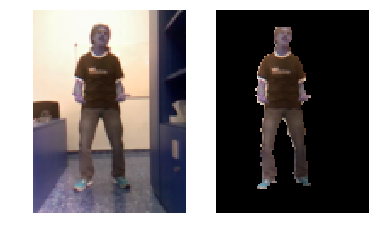

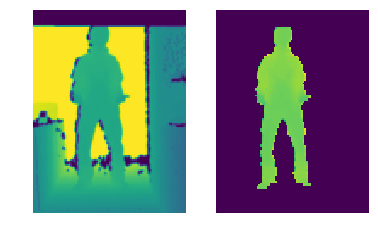

In [10]:
# A reference image.
sampleIdx = 20

# Fetch the segmentation mask of the reference image.
segmentedUser = data['segmentation'][sampleIdx]
mask2 = np.mean(segmentedUser, axis=2) > 150 # For depth images.
mask3 = np.tile(mask2, (3,1,1)) # For 3-channel images (rgb)
mask3 = mask3.transpose((1,2,0))

# Show the images.
plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(data['rgb'][sampleIdx]) # rgb image
plt.subplot(1, 2, 2)
plt.imshow(data['rgb'][sampleIdx]*mask3) # Masked rgb image
plt.axis("off")

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(data['depth'][sampleIdx]) # Depth image
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(data['depth'][sampleIdx]*mask2) # Masked depth image

In [5]:
# You may find other feature extraction techniques on: 
# http://scikit-image.org/docs/dev/api/skimage.feature.html
# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html

def visualizeHOG(img, orientations=8, pixels_per_cell=(16,16), cells_per_block=(4,4), widthPadding=10, plotTitle=None):
    """
    Calculates HOG feature vector for the given image.
    
    img is a numpy array of 2- or 3-dimensional image (i.e., grayscale or rgb). 
    Color-images are first transformed to grayscale since HOG requires grayscale 
    images.
    
    Reference: http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog
    """
    if len(img.shape) > 2:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # Crop the image from left and right.
    if widthPadding > 0:
        img = img[:, widthPadding:-widthPadding]
    
    # Note that we are using skimage.feature.
    hog_features, hog_image = feature.hog(img, orientations, pixels_per_cell, cells_per_block, visualise=True)
    
    # In order to visualize the result, you need to pass a plotTitle (you can remove the condition).
    if plotTitle is not None:
        plt.figure()
        plt.suptitle(plotTitle)
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(hog_image)
        plt.axis("off")
        
        print("[" + plotTitle + "] # Features: " + str(hog_features.shape))
    
def visualizeSIFT(img, contrastThreshold=0.04, edgeThreshold=10, widthPadding=10, plotTitle=None):
    """
    Calculates SIFT feature vector for the given image. Note that SIFT operation 
    detects arbitrary keypoints for different images.

    img is a numpy array of 2- or 3-dimensional image (i.e., grayscale or rgb). 

    Since SIFT can extract different # of key points per image, you can use nfeatures 
    parameter of the SIFT create() function in order to control it. 
    
    For details:
        [nfeatures]:The number of best features to retain. The features are
        ranked by their scores (measured in SIFT algorithm as the local contrast)
        [contrastThreshold]:The contrast threshold used to filter out weak features
        in semi-uniform (low-contrast) regions. The larger the threshold, the less
        features are produced by the detector.
        [edgeThreshold]:The threshold used to filter out edge-like features. Note
        that the its meaning is different from the contrastThreshold, i.e. the
        larger the edgeThreshold, the less features are filtered out (more
        features are retained).
        
    A tutorial: http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
    """
    # Crop the image from left and right.
    if widthPadding > 0:
        img = img[:, widthPadding:-widthPadding]
    
    # Create sift object.
    sift = cv2.xfeatures2d.SIFT_create(contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold)
    
    # detectAndCompute method first detects the keypoints and then calculates description vectors.
    # You may first use detect, and then compute methods as well. It is useful if you want to 
    # detect the keypoints for an image and then use the same keypoints on other images.
    (kp, descriptions) = sift.detectAndCompute(img, None)
    
    # In order to visualize the result, you need to pass a plotTitle (you can remove the condition).
    if plotTitle is not None:
        # For visualization
        imgSift = np.copy(img)
        imgSift=cv2.drawKeypoints(img,kp,imgSift,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        plt.figure()
        plt.suptitle(plotTitle)
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(imgSift)
        plt.axis("off")
        
        print("[" + plotTitle + "] # Features: " + str(descriptions.size))
        
def visualizeSIFTDense(img, pixelStepSize=10, widthPadding=10, plotTitle=None):
    """
    Calculates SIFT feature vector for the given image. First, a grid of keypoints 
    is created by scanning through the pixel locations of the image.
    Note that if you use the same grid for every image, then features will have the
    same locality for other images as well.

    img is a numpy array of 2- or 3-dimensional image (i.e., grayscale or rgb).
    """
    # Crop the image from left and right.
    if widthPadding > 0:
        img = img[:, widthPadding:-widthPadding]
    
    # Create sift object.
    sift = cv2.xfeatures2d.SIFT_create()
    
    # Create grid of key points.
    keypointGrid = [cv2.KeyPoint(x, y, pixelStepSize)
                    for y in range(0, img.shape[0], pixelStepSize)
                        for x in range(0, img.shape[1], pixelStepSize)]
    
    # Given the list of keypoints, compute the local descriptions for every keypoint.
    (kp, descriptions) = sift.compute(img, keypointGrid)
    
    if plotTitle is not None:    
        # For visualization
        imgSiftDense = np.copy(img)
        imgSiftDense=cv2.drawKeypoints(img,kp,imgSiftDense,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        plt.figure()
        plt.suptitle(plotTitle)
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(imgSiftDense)
        plt.axis("off")
        
        print("[" + plotTitle + "] # Features: " + str(descriptions.size))

[HOG-RGB] # Features: (512,)
[SIFT-RGB] # Features: 8448
[HOG-Masked RGB] # Features: (512,)
[SIFT-Masked RGB] # Features: 4224


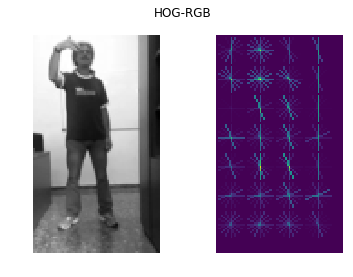

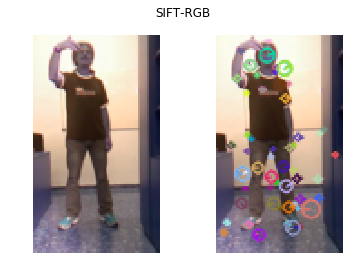

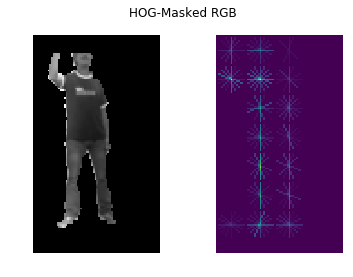

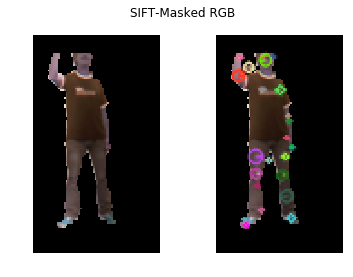

In [6]:
# RGB Modalidty
sourceImg = data['rgb'][sampleIdx]
visualizeHOG(sourceImg, plotTitle='HOG-RGB')
visualizeSIFT(sourceImg, plotTitle='SIFT-RGB')
# Masked RGB
maskedDepth = sourceImg * mask3
visualizeHOG(maskedDepth, plotTitle='HOG-Masked RGB')
visualizeSIFT(maskedDepth, plotTitle='SIFT-Masked RGB')

[HOG-Segmentation] # Features: (512,)
[SIFT-Segmentation] # Features: 6912


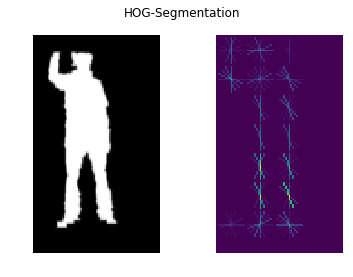

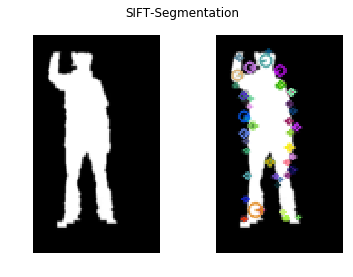

In [7]:
# Segmentation Mask Modality
sourceImg = data['segmentation'][sampleIdx]
visualizeHOG(sourceImg, plotTitle='HOG-Segmentation')
visualizeSIFT(sourceImg, plotTitle='SIFT-Segmentation')

[HOG-Depth] # Features: (512,)
[SIFT-Depth] # Features: 9216
[HOG-Masked Depth] # Features: (512,)
[SIFT-Masked Depth] # Features: 2560


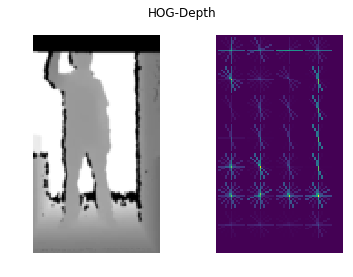

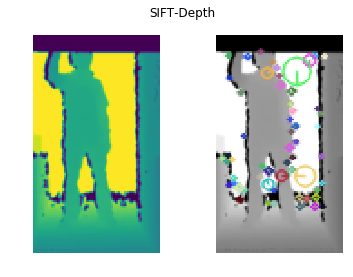

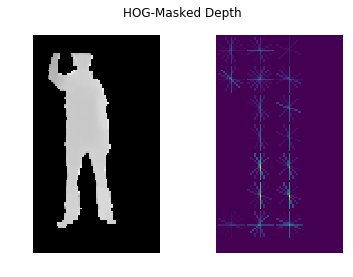

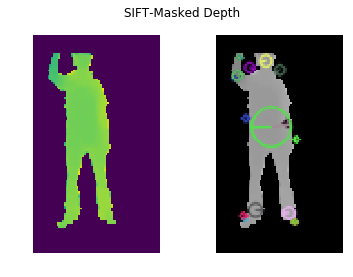

In [8]:
# Depth Modality
sourceImg = data['depth'][sampleIdx]
visualizeHOG(sourceImg, plotTitle='HOG-Depth')
visualizeSIFT(sourceImg, plotTitle='SIFT-Depth')
# Masked Depth
maskedDepth = sourceImg * mask2
visualizeHOG(maskedDepth, plotTitle='HOG-Masked Depth')
visualizeSIFT(maskedDepth, plotTitle='SIFT-Masked Depth')

[Dense SIFT-RGB] # Features: 3072
[Dense SIFT-Masked Depth] # Features: 5120


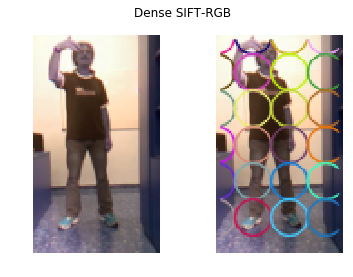

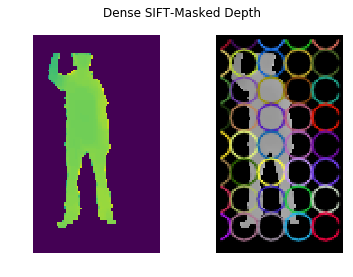

In [9]:
# Dense Sift
# RGB
img = data['rgb'][sampleIdx]
visualizeSIFTDense(img, pixelStepSize=20, plotTitle='Dense SIFT-RGB')
# Masked Depth
sourceImg = data['depth'][sampleIdx]
maskedDepth = sourceImg * mask2
visualizeSIFTDense(maskedDepth, pixelStepSize=15, plotTitle='Dense SIFT-Masked Depth')